# Import packages

In [1]:
# !pip install gensim
# !pip install nltk
# import nltk
# nltk.download('punkt')
# !pip install openai

In [2]:
import pandas as pd
import numpy as np
from openai import OpenAI
import os
import nltk
from gensim.models import KeyedVectors
import re
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

## Read files

In [3]:
df = pd.read_csv('webscraping_results_assignment3.csv')
df.head()

,Title,Company,Location,Date,Salary,Links,Descriptions,word_embedding_1,word_embedding_2,word_embedding_3,...,word_embedding_291,word_embedding_292,word_embedding_293,word_embedding_294,word_embedding_295,word_embedding_296,word_embedding_297,word_embedding_298,word_embedding_299,word_embedding_300
0,Principal Data Scientist,Navy Federal Credit Union,"Remote in San Diego, CA 92131",PostedPosted 9 days ago,NaN,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"Overview\nProvide independent data science, ma...",-0.031440,0.016353,0.029929,...,-0.071558,0.047671,-0.087272,0.007575,-0.020380,0.018765,0.038499,-0.031376,0.013722,-0.011149
1,Data Annotation Manager,Helm.ai,"Redwood City, CA",PostedPosted 1 day ago,$25 - $30 an hour,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"HireArt is seeking a bright, detail-oriented s...",-0.014846,0.012481,0.011582,...,-0.083651,0.059948,-0.080662,0.011461,-0.040070,0.014749,0.032535,-0.047182,0.020886,-0.025969
2,E-commerce Data Scientist - Health and Wellnes...,Stingray Direct,Remote in California,EmployerActive 7 days ago,"$110,000 - $130,000 a year",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,THE ROLE: E-commerce Data Scientist\nStingray ...,-0.012305,0.002649,0.004599,...,-0.054925,0.066405,-0.072332,0.023371,-0.016299,0.024141,0.051499,-0.014453,-0.001486,-0.018059
3,"Machine Learning Scientist, Prescient Design",Genentech,"South San Francisco, CA 94080",PostedPosted 4 days ago,NaN,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,The Position\nWe are seeking a highly motivate...,-0.016110,0.011494,0.033340,...,-0.093538,0.028029,-0.102869,0.036567,-0.022319,0.009812,0.035284,-0.021911,0.036437,-0.010617
4,Data Scientist,TikTok,"San Jose, CA 95110 (Downtown area)",PostedPosted 3 days ago,"$114,000 - $240,000 a year",https://www.indeed.com/rc/clk?jk=5105f54430df3...,Responsibilities\nTikTok is the leading destin...,-0.021747,0.026814,0.014422,...,-0.093381,0.039864,-0.079506,0.005015,-0.037432,0.030652,0.044266,-0.016716,0.028199,-0.019402


## Extract skills from job postings using N-grams

### Using Chatgpt API to get skills

In [4]:
API_KEY = "" #Insert your API key here
model = "gpt-3.5-turbo-16k"
max_tokens = 2000
n = 1
stop = None

In [5]:
prompt1 = "What words should look for to extract skills from the job description of data science job postings?"
client = OpenAI(
    api_key = API_KEY,
)

response1 = client.chat.completions.create(
    messages=[
        {"role":"system","content":"You are a helpful assistant."},
        {"role":"user","content":prompt1},
    ],
    model=model)

In [6]:
coutput1 = response1.choices[0].message.content
print(coutput1)

To extract skills from a data science job description, look for the following keywords:

1. Programming languages: Python, R, Java, SQL, Scala, etc.
2. Machine learning: Algorithms, models, classification, regression, clustering, deep learning, neural networks, natural language processing (NLP).
3. Statistical analysis: Hypothesis testing, A/B testing, data exploration, probability, statistical modeling.
4. Data manipulation: Data cleaning, preprocessing, feature engineering, data visualization.
5. Visualization and reporting: Tableau, PowerBI, data visualization libraries (Matplotlib, Seaborn, ggplot).
6. Big data technologies: Hadoop, Spark, Hive, Pig, MapReduce, etc.
7. Data mining: Web scraping, data extraction, text mining.
8. Data engineering: ETL (Extract, Transform, Load) processes, data pipelines, data warehousing.
9. Data storage: Relational databases (MySQL, PostgreSQL), NoSQL databases (MongoDB, Cassandra).
10. Experimentation and analysis: Design of experiments, hypothesis

In [7]:
#Initiate dictionary to store results
res = {}
res['Statistical Analysis'] = []
res['SPSS'] = []
res['SAS'] = []
res['Excel'] = []
res['R'] = []
res['SQL'] = []
res['Python'] = []
res['Machine Learning'] = []
res['Modeling'] = []
res['Optimization'] = []
res['Pandas'] = []
res['Numpy'] = []
res['Tableau'] = []
res['Power BI'] = []
res['Deep Learning'] = []
res['Artificial Intelligence'] = []
res['Tensor Flow'] = []
res['Pytorch'] = []
res['Spark'] = []
res['Hadoop'] = []
res['Big Data'] = []
res['Consulting'] = []
res['Negotiation'] = []
res['Business Intelligence'] = []
res['Teamwork'] = []
res['Creativity'] = []
res['Communication'] = []
res['Data Management'] = []
res['Data Mining'] = []
res['Scikit-learn'] = []
res['AWS'] = []

for i,row in df.iterrows():
    cleantext = str(row["Descriptions"]).lower()
    
    if ('statistical analysis' in cleantext)|('statistical model' in cleantext)|('statistical concept' in cleantext):
        res['Statistical Analysis'].append(1)
    else:
        res['Statistical Analysis'].append(0)
    if (' spss ' in cleantext)|(' spss,' in cleantext)|(' spss.' in cleantext):
        res['SPSS'].append(1)
    else:
        res['SPSS'].append(0)
    if (' sas ' in cleantext)|(' sas,' in cleantext)|(' sas.' in cleantext):
        res['SAS'].append(1)
    else:
        res['SAS'].append(0)
    if ('microsoft excel' in cleantext) | ('ms excel' in cleantext):
        res['Excel'].append(1)
    else:
        res['Excel'].append(0)
    if (' r ' in cleantext)|(' r,' in cleantext)|(' r.' in cleantext):
        res['R'].append(1)
    else:
        res['R'].append(0)
    if ('sql' in cleantext)|('structured quer' in cleantext):
        res['SQL'].append(1)
    else:
        res['SQL'].append(0)
    if ('python' in cleantext):
        res['Python'].append(1)
    else:
        res['Python'].append(0)
    if ('machine learning' in cleantext):
        res['Machine Learning'].append(1)
    else:
        res['Machine Learning'].append(0)
    if ('modeling' in cleantext)|('model' in cleantext):
        res['Modeling'].append(1)
    else:
        res['Modeling'].append(0)
    if ('optimization' in cleantext)|('optimize' in cleantext):
        res['Optimization'].append(1)
    else:
        res['Optimization'].append(0)
    if("databas" in cleantext) or ("data mana" in cleantext) or ("data ha" in cleantext) or ("data lak" in cleantext) or ("data war" in cleantext) or ("data eng" in cleantext)  or ("data proc" in cleantext):
        res['Data Management'].append(1)
    else:
        res['Data Management'].append(0)
    if ('pandas' in cleantext):
        res['Pandas'].append(1)
    else:
        res['Pandas'].append(0)
    if ('numpy' in cleantext):
        res['Numpy'].append(1)
    else:
        res['Numpy'].append(0)
    if ('tableau' in cleantext):
        res['Tableau'].append(1)
    else:
        res['Tableau'].append(0)
    if ('power bi' in cleantext):
        res['Power BI'].append(1)
    else:
        res['Power BI'].append(0)
    if ('deep learning' in cleantext):
        res['Deep Learning'].append(1)
    else:
        res['Deep Learning'].append(0)
    if ('artificial intelligence' in cleantext):
        res['Artificial Intelligence'].append(1)
    else:
        res['Artificial Intelligence'].append(0)
    if ('tensorflow' in cleantext):
        res['Tensor Flow'].append(1)
    else:
        res['Tensor Flow'].append(0)
    if ('pytorch' in cleantext):
        res['Pytorch'].append(1)
    else:
        res['Pytorch'].append(0)
    if ('spark' in cleantext):
        res['Spark'].append(1)
    else:
        res['Spark'].append(0)
    if ('hadoop' in cleantext):
        res['Hadoop'].append(1)
    else:
        res['Hadoop'].append(0)
    if ('big data' in cleantext):
        res['Big Data'].append(1)
    else:
        res['Big Data'].append(0)    
    if ('consulting' in cleantext)|('consultation' in cleantext):
        res['Consulting'].append(1)
    else:
        res['Consulting'].append(0)
    if ('negotiate' in cleantext):
        res['Negotiation'].append(1)
    else:
        res['Negotiation'].append(0)
    if (' bi ' in cleantext)|('business analytics' in cleantext)|('business intelligence' in cleantext):
        res['Business Intelligence'].append(1)
    else:
        res['Business Intelligence'].append(0)
    if ('teamwork' in cleantext)|(' team ' in cleantext)|(' teams' in cleantext):
        res['Teamwork'].append(1)
    else:
        res['Teamwork'].append(0)
    if ('creativ' in cleantext)|('creative' in cleantext)|(('creat' in cleantext)):
        res['Creativity'].append(1)
    else:
        res['Creativity'].append(0)
    if ('communication' in cleantext):
        res['Communication'].append(1)
    else:
        res['Communication'].append(0)
    if ('data mining' in cleantext):
        res['Data Mining'].append(1)
    else:
        res['Data Mining'].append(0)
    if ('scikit' in cleantext):
        res['Scikit-learn'].append(1)
    else:
        res['Scikit-learn'].append(0)
    if (' aws ' in cleantext)|(' aws.' in cleantext)|(' aws,' in cleantext):
        res['AWS'].append(1)
    else:
        res['AWS'].append(0)
ngrams = pd.DataFrame(res)

In [8]:
#Combine results to df
ngrams = pd.DataFrame(res)
ngrams.head()

,Statistical Analysis,SPSS,SAS,Excel,R,SQL,Python,Machine Learning,Modeling,Optimization,...,Consulting,Negotiation,Business Intelligence,Teamwork,Creativity,Communication,Data Management,Data Mining,Scikit-learn,AWS
0,0,1,1,0,1,1,1,1,1,1,...,0,0,0,1,1,1,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,1,1,1,1,1,...,0,0,0,1,1,1,0,0,0,0
3,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,1,1,1,1,...,0,0,0,1,1,1,1,0,0,0


### Plots

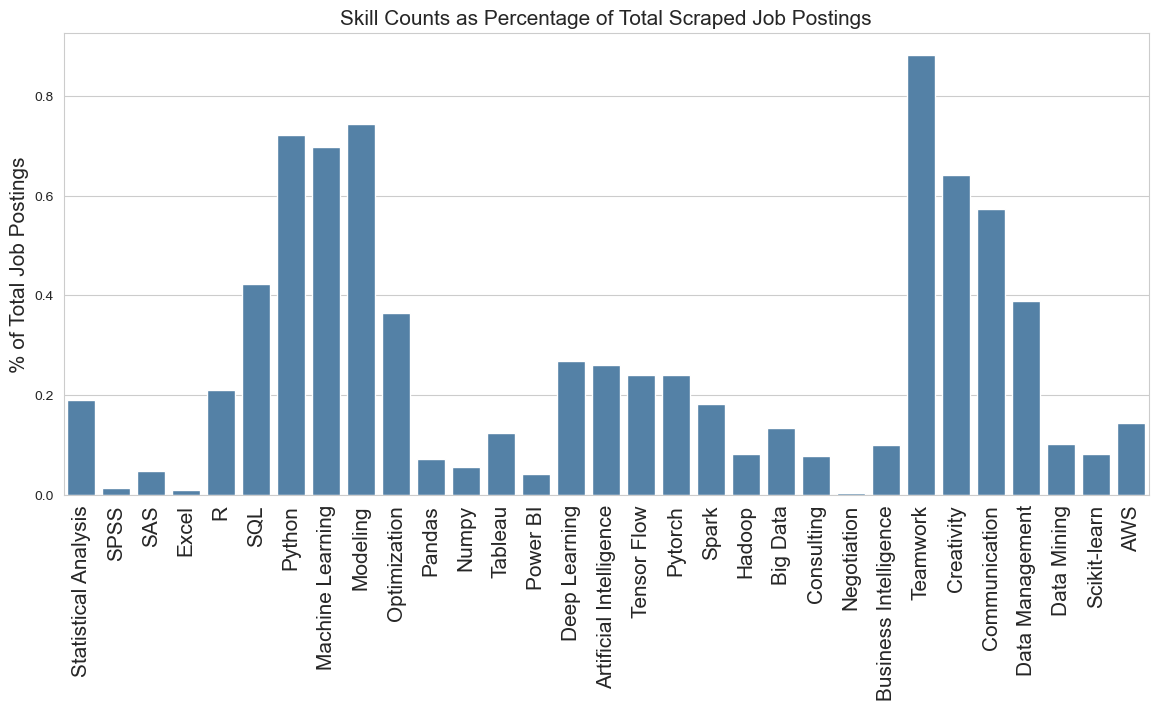

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(14,6))
ax = sns.barplot(x=ngrams.sum().index, y=ngrams.sum().values/ngrams.shape[0],color='steelblue')
ax.set_title('Skill Counts as Percentage of Total Scraped Job Postings',fontsize=15)
ax.set_ylabel('% of Total Job Postings',fontsize=15)
plt.xticks(rotation=90,fontsize=15)
plt.show()

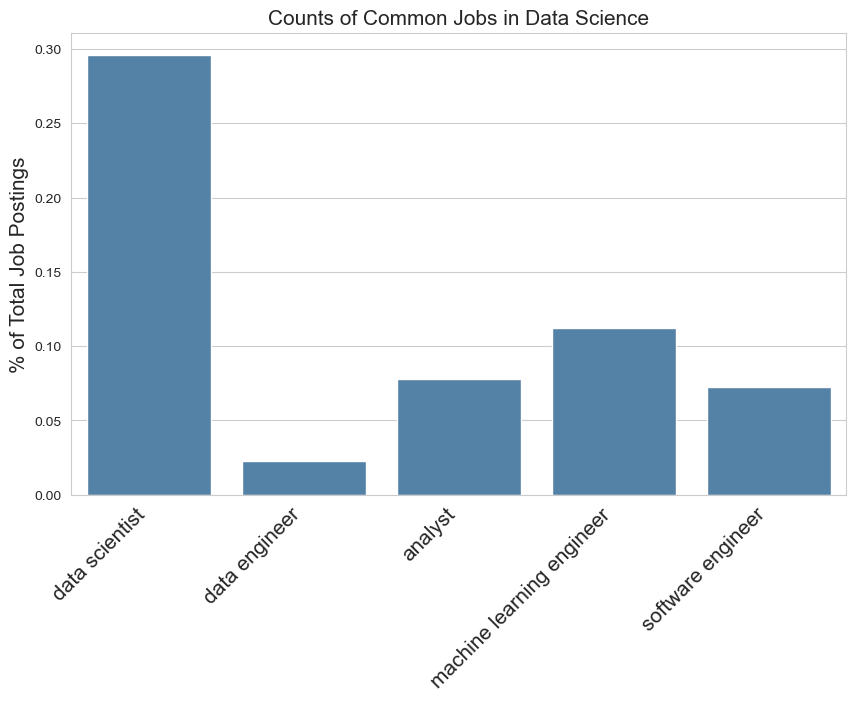

In [10]:
job_list = ['data scientist','data engineer','analyst','machine learning engineer','software engineer']
job_count = [df['Title'].str.lower().str.contains(job).sum()/ngrams.shape[0] for job in job_list]

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
ax = sns.barplot(x=job_list, y=job_count,color='steelblue')
ax.set_title('Counts of Common Jobs in Data Science',fontsize=15)
ax.set_ylabel('% of Total Job Postings',fontsize=15)
plt.xticks(rotation=45,fontsize=15,ha='right')
plt.show()

## Word embeddings

Commented out cells are the cells I ran to get the word embeddings

In [11]:
# #Load word2vec model
# model_path = r"C:\Users\ASUS\Documents\UofT MEng\Fall 2023-2024\CME538\Big project\GoogleNews-vectors-negative300.bin.gz"
# word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [12]:
# #Function to clean text strings
# def clean_text(x):
#     """
#     input- string (x)
#     output- string without punctuations and only lower case letters
#     """
#     return re.sub(r'[^a-zA-Z\s]', '', x).lower()

# #Function to perform word embedding on a given column
# def word_embed(x,model):
#     """
#     input:
#     x- string of any length
#     model- pre-trained NLP model
    
#     output:
#     array of shape (300,1) representing embedding of given string
#     """
#     tokens = nltk.word_tokenize(clean_text(x))     #tokenize text string
#     vectors = [model.get_vector(word) for word in tokens if word in model.key_to_index]   #Compile list of vectors
#     vector_final = np.sum(vectors,axis=0)/len(vectors)   #Average the compiled word vectors
#     vector_final = vector_final.reshape(1,-1).flatten()    #reshape vector and flatten the averaged vectors
#     columns = [f'word_embedding_{i+1}' for i in range(vector_final.shape[0])]
#     return pd.Series(vector_final, index=columns)

In [ ]:
# word_embeddings = df['Descriptions'].apply(lambda x: word_embed(x,word2vec_model)).fillna(0)
# word_embeddings

In [12]:
#View word embeddings
word_embeddings = df.filter(like='word_embedding', axis=1)
word_embeddings

,word_embedding_1,word_embedding_2,word_embedding_3,word_embedding_4,word_embedding_5,word_embedding_6,word_embedding_7,word_embedding_8,word_embedding_9,word_embedding_10,...,word_embedding_291,word_embedding_292,word_embedding_293,word_embedding_294,word_embedding_295,word_embedding_296,word_embedding_297,word_embedding_298,word_embedding_299,word_embedding_300
0,-0.031440,0.016353,0.029929,0.067406,-0.038619,-0.015998,0.032750,-0.075855,0.057610,0.006855,...,-0.071558,0.047671,-0.087272,0.007575,-0.020380,0.018765,0.038499,-0.031376,0.013722,-0.011149
1,-0.014846,0.012481,0.011582,0.050839,-0.064347,0.002759,0.019617,-0.089499,0.064237,0.014450,...,-0.083651,0.059948,-0.080662,0.011461,-0.040070,0.014749,0.032535,-0.047182,0.020886,-0.025969
2,-0.012305,0.002649,0.004599,0.073081,-0.035477,0.011829,0.033609,-0.060064,0.081580,0.008245,...,-0.054925,0.066405,-0.072332,0.023371,-0.016299,0.024141,0.051499,-0.014453,-0.001486,-0.018059
3,-0.016110,0.011494,0.033340,0.081432,-0.055318,-0.001631,0.040116,-0.086441,0.051864,0.028925,...,-0.093538,0.028029,-0.102869,0.036567,-0.022319,0.009812,0.035284,-0.021911,0.036437,-0.010617
4,-0.021747,0.026814,0.014422,0.066153,-0.053378,-0.003100,0.052937,-0.068995,0.055151,0.009980,...,-0.093381,0.039864,-0.079506,0.005015,-0.037432,0.030652,0.044266,-0.016716,0.028199,-0.019402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,-0.043364,0.030208,0.022408,0.063295,-0.032897,-0.001574,0.036637,-0.071640,0.067709,-0.003981,...,-0.081223,0.023747,-0.077281,0.035412,-0.026295,0.041900,0.022007,-0.018589,0.038710,-0.010270
1063,-0.039196,0.002190,0.017871,0.044352,-0.040862,-0.020955,0.030980,-0.059885,0.067947,0.009401,...,-0.082502,0.045598,-0.060287,0.026820,-0.008575,0.023328,0.035562,-0.028182,0.006405,-0.032460
1064,-0.000810,0.013617,0.023588,0.083959,-0.050497,-0.003296,0.044150,-0.065642,0.054104,0.033120,...,-0.071743,0.058837,-0.087238,0.014286,-0.008780,0.017365,0.034270,-0.016198,0.017875,-0.023645
1065,-0.022509,0.014503,0.030997,0.095963,-0.051159,0.003669,0.045356,-0.044599,0.055732,0.009310,...,-0.075479,0.022813,-0.074911,0.031333,0.005660,0.018760,0.016550,-0.043772,0.012207,-0.015691


## Hierarchical Clustering

In [13]:
# Empty matrix to store differences
D = np.zeros([ngrams.shape[1], ngrams.shape[1]])

# Find all element-wise temp differences
for k in range(ngrams.shape[0]):
    for i in range(ngrams.shape[1]):
        for j in range(ngrams.shape[1]):
            # Calculate the element-wise difference and store in the matrix
            D[i, j] += abs(ngrams.iloc[k, i] - ngrams.iloc[k, j])

In [14]:
Y = sch.linkage(D, method='complete',metric='euclidean')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7816\3237624032.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete',metric='euclidean')


[]

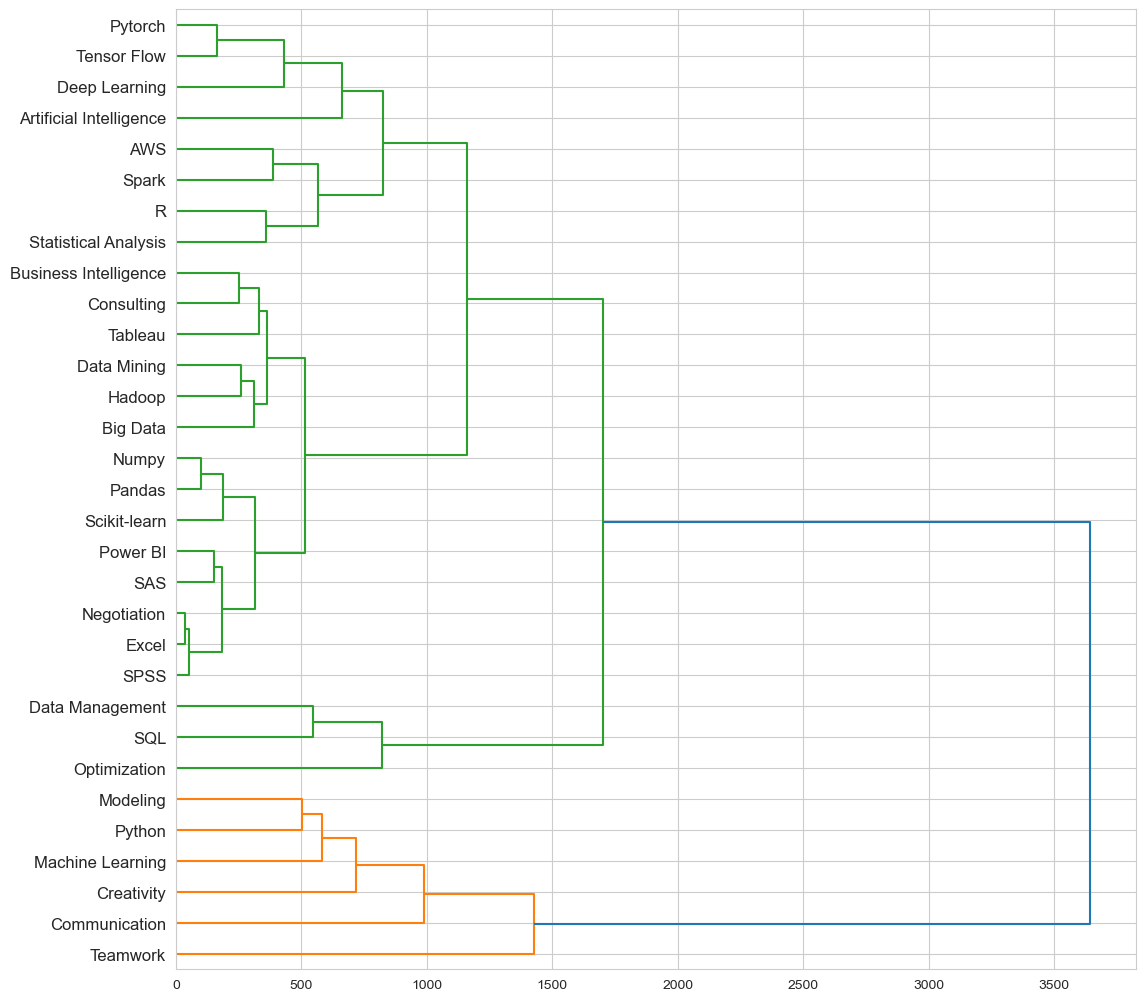

In [15]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
Z1 = sch.dendrogram(Y, orientation='right')
labels = ngrams.columns[Z1['leaves']]
ax.set_yticklabels(labels,fontsize=12)

plt.plot()

## Generating features for KMeans Clustering

### Clustering word embeddings

In [16]:
# Standardize word embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(word_embeddings)

In [17]:
# Apply KMeans for a range of clusters and fit to word embeddings
inertia = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k,random_state=43)
    kmeans.fit(scaled_embeddings)
    inertia.append(kmeans.inertia_)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

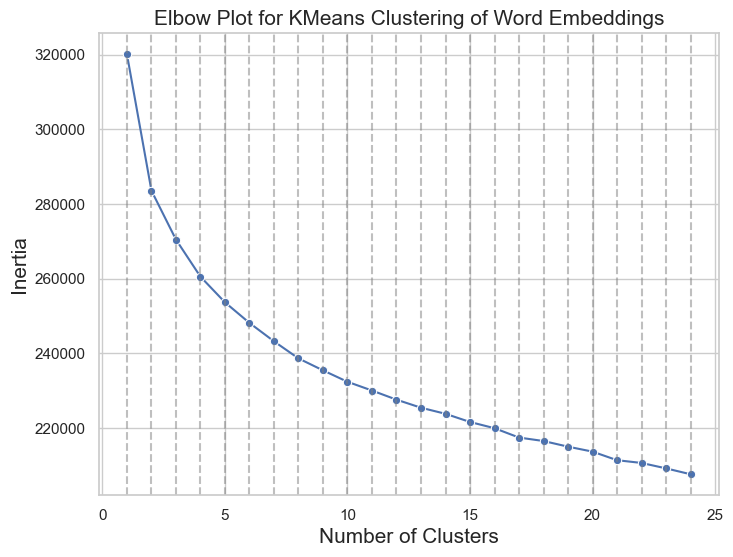

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, 25), y=inertia, marker='o')
plt.title('Elbow Plot for KMeans Clustering of Word Embeddings',fontsize=15)
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Inertia',fontsize=15)
for x_tick in range(1, 25):
    plt.axvline(x=x_tick, linestyle='--', color='gray', alpha=0.5)
plt.show()

In [19]:
#Fit kmeans with k=8 clusters to word embeddings 
kmeans = KMeans(n_clusters=8, random_state=43)
ngrams['Cluster'] = kmeans.fit_predict(scaled_embeddings)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


### Salary

In [20]:
#Clean salaries column
def extract_salary(salary_str):
    if pd.isna(salary_str):
        return np.nan
    if '-' in salary_str:
        if '.' in salary_str:
            salaries = salary_str.replace(' ','').split('-')
            salaries = [float(''.join(re.findall(r'\d+', salary)))/100 for salary in salaries]
            if 'hour' in salary_str:
                return np.mean(salaries) * 40 * 52
            else:
                return np.mean(salaries)            
        else:
            salaries = salary_str.replace(' ','').split('-')
            salaries = [float(''.join(re.findall(r'\d+', salary))) for salary in salaries]
            if 'hour' in salary_str:
                return np.mean(salaries) * 40 * 52
            else:
                return np.mean(salaries)
    else:
        return float(''.join(re.findall(r'\d+', salary_str)))

In [21]:
ngrams['Salary'] = df['Salary'].apply(extract_salary)

### Education

In [22]:
#Extract 10 strings in front of all 'degree' mentioned in description
def extract_education(description):
    pattern = r'(.{1,10}\s){0,10}degree'
    matches = re.findall(pattern, description)
    return matches

In [23]:
extracted_education = df['Descriptions'].apply(extract_education)
ngrams["Bachelor's"] = extracted_education.apply(lambda x: sum('bachelor' in word.lower() for word in x))
ngrams["Master's"] = extracted_education.apply(lambda x: sum(('master' in word.lower() or 'grad' in word.lower()) for word in x))
ngrams["PHD"] = extracted_education.apply(lambda x: sum(('doc' in word.lower() or 'phd' in word.lower()) for word in x))

### Years of experience

In [24]:
#Extract 6 strings in front of all 'years' mentioned in description
def extract_years(description):
    pattern = r'(.{1,6}\s){0,6}years'
    matches = re.findall(pattern, description)
    matches = [i.replace('two', '2').replace('three', '3').replace('four', '4').replace('five', '5')\
               .replace('six', '6').replace('seven', '7').replace('eight', '8').replace('nine', '9')\
               .replace('ten', '10') for i in matches]
    matches = [''.join(filter(str.isdigit, str(item))) for item in matches]
    return matches

In [25]:
# Custom function to calculate mean while excluding values greater than 20
def clean_years(lst):
    # Remove non-numeric values and values greater than 20
    filtered_values = [float(value) for value in lst if pd.notna(value) and value.replace('.', '', 1).isdigit() and float(value) <= 20]
    
    # Calculate mean or return np.nan for empty lists
    return np.mean(filtered_values) if filtered_values else np.nan

In [26]:
years = df['Descriptions'].apply(extract_years)
ngrams['Years of Experience'] = years.apply(clean_years)

### Length of job title

In [27]:
ngrams['Title Length'] = df['Title'].apply(lambda x:len(x))

### Is the job title a management role

In [28]:
ngrams['Is Managerial Role'] = df['Title'].str.lower().str.contains('lead|manager|chief|senior|head', case=False, regex=True)

### Compile features as dataframe

In [29]:
#Initiate dictionary called features to store features for KMeans clustering on skills
features = {}
features['Cluster'] = []
features['Skill Frequency'] = []
features['Soft/Hard skills'] = []
features['Average Salary'] = []
features["Bachelor's Degree Frequency"] = []
features["Master's Degree Frequency"] = []
features["PHD Degree Frequency"] = []
features['Years of Experience'] = []
features['Average Length of Job Title'] = []
features['Is Management Title'] = []

#Specify list of soft skills
soft_skills = ['Consulting','Negotiation','Teamwork','Creativity','Communication']

#Get Cluster label for each skill
for col in ngrams.columns[:31]:
    
    #Get cluster label with highest frequency in each skill
    cluster_labels = ngrams.loc[ngrams[col]==1,'Cluster'].value_counts().idxmax()
    
    #Skill frequency
    skill_freq = ngrams[col].sum()
    
    #Soft or hard skill
    if col in  soft_skills:
        features['Soft/Hard skills'].append(1)
    else:
        features['Soft/Hard skills'].append(0)
    
    #Average salary
    avg_salary = np.mean(ngrams.loc[ngrams[col]==1,'Salary'])
    
    #Education level
    bachelors_freq = ngrams.loc[ngrams[col]==1,"Bachelor's"].sum()
    masters_freq = ngrams.loc[ngrams[col]==1,"Master's"].sum()
    phd_freq = ngrams.loc[ngrams[col]==1,"PHD"].sum()
    
    #Years of Experience
    years_of_exp = np.mean(ngrams.loc[ngrams[col]==1,'Years of Experience'])
    
    #Average length of job title
    title_length = np.mean(ngrams.loc[ngrams[col]==1,'Title Length'])
    
    #Frequency of jobs with managerial titles
    is_managerial = ngrams.loc[ngrams[col]==1,'Is Managerial Role'].sum()
    
    #Append results to list
    features['Cluster'].append(cluster_labels)
    features['Skill Frequency'].append(skill_freq)
    features['Average Salary'].append(avg_salary)
    features["Bachelor's Degree Frequency"].append(bachelors_freq)
    features["Master's Degree Frequency"].append(masters_freq)
    features["PHD Degree Frequency"].append(phd_freq)
    features['Years of Experience'].append(years_of_exp)
    features['Average Length of Job Title'].append(title_length)
    features['Is Management Title'].append(is_managerial)

In [30]:
features = pd.DataFrame(features,index=ngrams.columns[:31])
features.head()

,Cluster,Skill Frequency,Soft/Hard skills,Average Salary,Bachelor's Degree Frequency,Master's Degree Frequency,PHD Degree Frequency,Years of Experience,Average Length of Job Title,Is Management Title
Statistical Analysis,1,203,0,162483.419565,81,79,17,5.039706,29.453202,71
SPSS,7,15,0,119879.200000,15,12,2,4.583333,31.733333,3
SAS,7,51,0,121486.190476,26,31,7,4.774123,34.098039,12
Excel,7,9,0,97515.000000,3,2,0,4.333333,25.777778,6
R,1,224,0,154706.507356,85,101,15,4.953205,31.482143,66


## KMeans of skills

In [31]:
# Standardize word embeddings
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [32]:
# Apply KMeans for a range of clusters and fit to word embeddings
inertia = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k,random_state=20)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

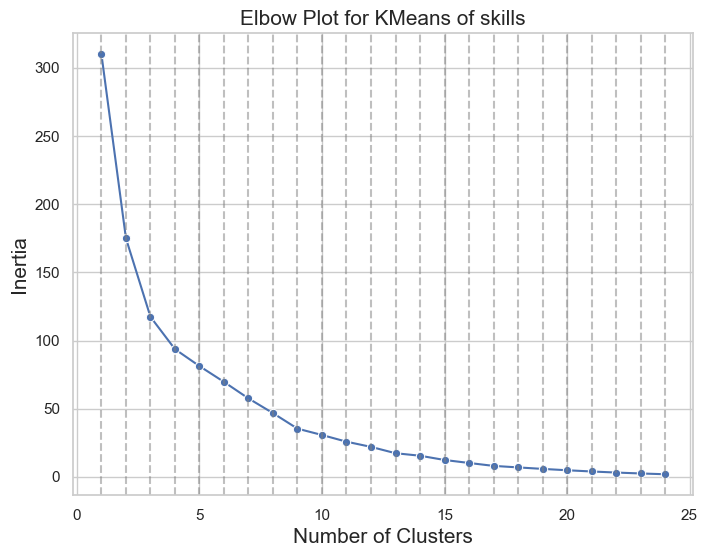

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, 25), y=inertia, marker='o')
plt.title('Elbow Plot for KMeans of skills',fontsize=15)
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Inertia',fontsize=15)
for x_tick in range(1, 25):
    plt.axvline(x=x_tick, linestyle='--', color='gray', alpha=0.5)
plt.show()

In [34]:
#pca on scaled features:
pca = PCA(n_components=2)
reduced_features = pd.DataFrame(pca.fit_transform(scaled_features),index=features.index,columns=['PC1','PC2'])

#Fit kmeans with k=9 clusters to word embeddings 
kmeans = KMeans(n_clusters=9, random_state=20)
reduced_features['Cluster'] = kmeans.fit_predict(scaled_features)

#View results
reduced_features.head()

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PC1,PC2,Cluster
Statistical Analysis,-0.712631,-0.004308,3
SPSS,-2.776989,2.682214,0
SAS,-2.111298,2.150720,0
Excel,-3.729375,4.095793,0
R,-0.596540,0.232829,3


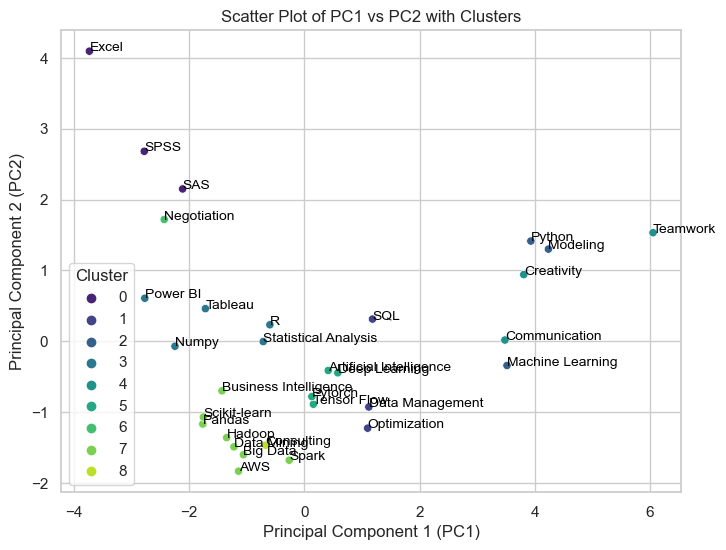

In [35]:
#Get hue order for plot
hue_order= [str(x) for x in sorted(reduced_features['Cluster'].unique())]
reduced_features['Cluster'] = reduced_features['Cluster'].astype(str)

# Scatter plot with seaborn
plt.figure(figsize=(8, 6))
plot = sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_features, palette='viridis',hue_order=hue_order)

# Set plot title and labels
plt.title('Scatter Plot of PC1 vs PC2 with Clusters')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Annotate points with index labels
for line in range(0, reduced_features.shape[0]):
    plot.text(reduced_features['PC1'][line], reduced_features['PC2'][line], reduced_features.index[line], horizontalalignment='left', size='small', color='black')

plt.legend(loc='lower left', title='Cluster')

# Show the plot
plt.show()

## Full course curriculum (bonus q)

In [53]:
prompt2 = "The hierarchical clustering results grouped certain skills together. Here are the clusters and skills grouped together:\
            Cluster 1: Pytorch, Tensor flow, Deep learning, Artificial intelligence\
            Cluster 2: AWS, Spark, R, Statistical analysis\
            Cluster 3: Business Intelligence, Consulting, Tableau\
            Cluster 4: Data mining, Hadoop, Big data\
            Cluster 5: Numpy, Pandas, Scikit learn\
            Cluster 6: Power BI, SAS, SPSS, Negotiation, Excel\
            Cluster 7: Data management, SQL, optimization\
            Cluster 8: Modeling, Python, Machine learning\
            Cluster 9: Creativity, Communication, Teamwork\
            With these results, design a detailed full program curriculum."
client = OpenAI(
    api_key = API_KEY,
)

response2 = client.chat.completions.create(
    messages=[
        {"role":"system","content":"You are a helpful assistant."},
        {"role":"user","content":prompt2},
    ],
    model=model)

In [54]:
coutput2 = response2.choices[0].message.content
print(coutput2)

Based on the hierarchical clustering results, we can design a comprehensive program curriculum that covers a variety of skills and knowledge areas. Here's a suggested breakdown of the curriculum based on the identified clusters:

Cluster 1: Pytorch, Tensor flow, Deep learning, Artificial intelligence

- Introduction to Artificial Intelligence
- Fundamentals of Deep Learning
- PyTorch and TensorFlow Frameworks
- Advanced Deep Learning Techniques
- Computer Vision and Natural Language Processing in AI
- AI Model Evaluation and Deployment

Cluster 2: AWS, Spark, R, Statistical analysis

- Introduction to Cloud Computing and AWS
- AWS Services and Architecture
- Data Processing with Apache Spark
- Statistical Analysis with R
- Exploratory Data Analysis
- Predictive Modeling using R

Cluster 3: Business Intelligence, Consulting, Tableau

- Business Intelligence Fundamentals
- Data Visualization Principles
- Advanced Tableau Techniques
- Designing Interactive Dashboards with Tableau
- Consul